In [1]:
!pip install patchify
!pip install opencv-python-headless
!pip install scikit-learn
!pip install tifffile
!pip install split-folders
!pip install segmentation-models==1.0.1
!pip install tensorflow

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 220 kB 7.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 50 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 44.0 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 59.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consid

In [2]:
import os
import cv2
import glob
import numpy as np
from patchify import patchify
import tifffile as tiff
from PIL import Image
import random
from matplotlib import pyplot as plt
import splitfolders
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pickle
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import classification_report
import pandas as pd

Segmentation Models: using `tf.keras` framework.


## Data Preprocesing

In [161]:
def patchify_single_image(image_path, root_directory, patch_size, output_folder):

    """
    - This function needs three parameters.
        - The path of the image
        - The path of the root directory
        - The size of the patches that is required(128,256...)
    - This functions reads the image, calculates the dimensions (SIZE_X for width and SIZE_Y for height) that are multiples of the patch_size.
      Ensuring that the image can be divided into non-overlapping patches of the specified patch_size
    - After performing the above operations, it stores the patches into the output_directory of images and masks respectively.

    - Cropping over resizing
       - Preservation of Aspect Ratio
       - Avoiding Interpolation(Especially for masks)
       - Handling Large Images
    """

    if output_folder == 'image':
        image = cv2.imread(os.path.join(image_path), 1) #Read the image in RGB form
    else:
        image = cv2.imread(os.path.join(image_path), 0) #Read the image in GRAYSCALE from
    SIZE_X = (image.shape[1] // patch_size) * patch_size # Calculate the nearest width dimension multiple of 'patch_size'
    SIZE_Y = (image.shape[0] // patch_size) * patch_size # Calculate the nearest height dimension multiple of 'patch_size'
    image = Image.fromarray(image) # Convert the image to a PIL Image object
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop the image to the calculated dimensions starting from the top-left corner
    image = np.array(image) # Convert the cropped PIL Image back to a NumPy array

    # Generate patches for the image with specified dimensions and step size
    if output_folder == 'image':
        patches_img = patchify(image, (patch_size, patch_size, 3),step = patch_size)
        #(37, 35, 1, 256, 256, 3) output shape of numpy array produced by patchify for images

    else:
        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)
        #(37, 35, 256, 256) output shape of numpy array produced by patchify for masks

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :] # Extract a single patch

            #Drop the extra unecessary dimension that patchify adds.This applies only for images and not masks 
            single_patch_img = single_patch_img[0] if "image" else single_patch_img 

            output_dir = os.path.join(root_directory, f"patched_data/{output_folder}")
            os.makedirs(output_dir, exist_ok=True)

            patch_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_patch_{i}{j}.tif"
            patch_path = os.path.join(output_dir, patch_filename)

            cv2.imwrite(patch_path, single_patch_img)
            print(f"Saved patch: {patch_path}")


In [156]:
def patchify_images(root_directory, patch_size=256, folder_names=["images", "masks"]):
    """
    This function fetches data stored in images and masks folders and passes them to patchify_single_image function for further processing.
    """
    for folder_name in folder_names:
        dir_path = os.path.join(root_directory, folder_name)
        for path, subdirs, files in os.walk(dir_path):
            for file_name in files:
                if file_name.endswith(".tif"):
                    file_path = os.path.join(path, file_name)
                    print(file_path)
                    patchify_single_image(file_path, root_directory, patch_size, folder_name)
                

In [160]:
root_directory = 'landcover/'
patchify_images(root_directory, patch_size=256)

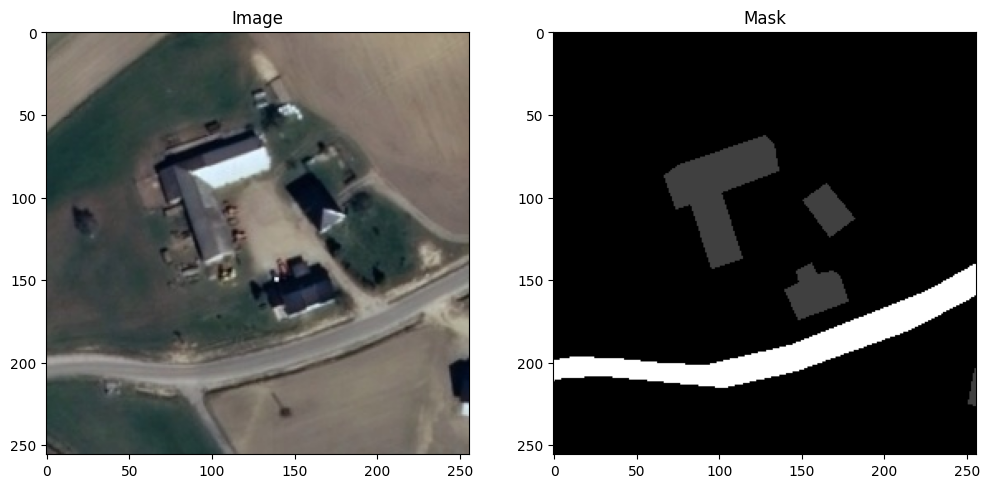

In [131]:
train_img_dir = "landcover/patched_data/images/"
train_mask_dir = "landcover/patched_data/masks/"

img_list = os.listdir(train_img_dir)
img_list = sorted(img_list)
msk_list = os.listdir(train_mask_dir)
msk_list = sorted(msk_list)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [162]:
def process_images_and_masks(img_list, msk_list, train_img_dir, train_mask_dir, output_dir, threshold=0.05):
    """
    This code assesses the utility of image-mask pairs based on the percentage of non-background labels in the mask image.
    Images with a sufficient amount of non-background information are considered "useful" and are saved, while others are labeled as "useless."

    The motive behind this is to work with data that have valuable infromation in all images for majority of labels.
    """

    for idx, (img_name, mask_name) in enumerate(zip(img_list, msk_list), 1):
        
        temp_image = cv2.imread(os.path.join(train_img_dir, img_name), 1)
        temp_mask = cv2.imread(os.path.join(train_mask_dir, mask_name), 0)

        val, counts = np.unique(temp_mask, return_counts=True) #Calculates the unique labels in the mask image and their corresponding counts using np.unique.
        non_zero_percentage = 1 - (counts[0] / counts.sum()) #Percentage represents the proportion of non-zero (i.e., non-background) pixels in the mask

        if non_zero_percentage > threshold:
            save_image_path = os.path.join(output_dir, 'images', img_name)
            save_mask_path = os.path.join(output_dir, 'masks', mask_name)

            os.makedirs(os.path.dirname(save_image_path), exist_ok=True)
            os.makedirs(os.path.dirname(save_mask_path), exist_ok=True)

            cv2.imwrite(save_image_path, temp_image)
            cv2.imwrite(save_mask_path, temp_mask)


In [163]:
train_img_dir = 'landcover/patche_data/images'
train_mask_dir = 'landcover/patche_data/masks'
output_dir = 'landcover/patches/filtered_images'

process_images_and_masks(img_list, msk_list, train_img_dir, train_mask_dir, output_dir, threshold=0.05)


# Model Training

In [4]:
class ImageSegmentationTrainer:
    def __init__(self, train_img_path, train_mask_path, val_img_path, val_mask_path, num_classes, model_save_path,save_history_path,backbone='resnet18'):
        self.train_img_path = train_img_path
        self.train_mask_path = train_mask_path
        self.val_img_path = val_img_path
        self.val_mask_path = val_mask_path
        self.num_classes = num_classes
        self.backbone = backbone
        self.preprocess_input = sm.get_preprocessing(self.backbone)
        self.seed = 24
        self.batch_size = 16
        self.model_save_path = model_save_path
        self.save_history_path = save_history_path

    def preprocess_data(self, img, mask):
        scaler = MinMaxScaler()
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img = self.preprocess_input(img)
        mask = to_categorical(mask, self.num_classes)
        return img, mask

    def data_generator(self, img_path, mask_path):
        img_data_gen_args = dict( rotation_range=90,
                                  horizontal_flip=True,
                                  width_shift_range=0.9,
                                  height_shift_range=0.9,
                                  vertical_flip=True,
                                 fill_mode='reflect')
        
        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)
        
        image_generator = image_datagen.flow_from_directory(
            img_path,
            class_mode=None,
            batch_size=self.batch_size,
            seed=self.seed)
        mask_generator = mask_datagen.flow_from_directory(
            mask_path,
            class_mode=None,
            color_mode='grayscale',
            batch_size=self.batch_size,
            seed=self.seed)
        generator = zip(image_generator, mask_generator)
        for (img, mask) in generator:
            img, mask = self.preprocess_data(img, mask)
            yield img, mask

    def train(self, epochs=20):
        train_img_gen = self.data_generator(self.train_img_path, self.train_mask_path)
        val_img_gen = self.data_generator(self.val_img_path, self.val_mask_path)

        num_train_imgs = len(os.listdir(os.path.join(self.train_img_path, 'images')))
        num_val_imgs = len(os.listdir(os.path.join(self.val_img_path, 'images')))
        steps_per_epoch = num_train_imgs // self.batch_size
        val_steps_per_epoch = num_val_imgs // self.batch_size
        
        x, y = train_img_gen.__next__()
        
        
        
        IMG_HEIGHT = x.shape[1]
        IMG_WIDTH = x.shape[2]
        IMG_CHANNELS = x.shape[3]
        
        
        model = sm.FPN(self.backbone, encoder_weights='imagenet',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                        classes=self.num_classes, activation='softmax')
        
        
        model.compile('Adam', loss= sm.losses.categorical_focal_jaccard_loss , metrics=[sm.metrics.iou_score])

        history = model.fit(train_img_gen,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            verbose=1,
                            validation_data=val_img_gen,
                            validation_steps=val_steps_per_epoch)
        
        model.save(self.model_save_path)
        
        with open(self.save_history_path, 'wb') as history_file:
            pickle.dump(history.history, history_file)
        
        return history
        
        
        
        
    


In [5]:
train_img_path = "landcover/train_images/"
train_mask_path = "landcover/train_masks/"
val_img_path = "landcover/val_images/"
val_mask_path = "landcover/val_masks/"
model_save_path = 'landcover/trained_models/landcover_20_epochs_RESNET18_backbone_batch16_FPN.hdf5'
save_history_path = 'landcover/trained_models/history_resnet18_epoch20_FPN.pkl' 
num_classes = 5
trainer = ImageSegmentationTrainer(train_img_path, train_mask_path, val_img_path, val_mask_path, num_classes,model_save_path,save_history_path)
trainer.train(epochs=20)

Found 15346 images belonging to 2 classes.
Found 15346 images belonging to 2 classes.
44920640/44920640 [==============================] - 1s 0us/step
Epoch 1/20
959/959 [==============================] - ETA: 0s - loss: 0.5702 - iou_score: 0.4720Found 4384 images belonging to 2 classes.
Found 4384 images belonging to 2 classes.
959/959 [==============================] - 1866s 2s/step - loss: 0.5702 - iou_score: 0.4720 - val_loss: 1.1952 - val_iou_score: 0.1014
Epoch 2/20
959/959 [==============================] - 1757s 2s/step - loss: 0.5057 - iou_score: 0.5311 - val_loss: 0.7395 - val_iou_score: 0.3713
Epoch 3/20
959/959 [==============================] - 1642s 2s/step - loss: 0.4807 - iou_score: 0.5532 - val_loss: 0.5158 - val_iou_score: 0.5215
Epoch 4/20
959/959 [==============================] - 1484s 2s/step - loss: 0.4527 - iou_score: 0.5788 - val_loss: 0.4829 - val_iou_score: 0.5478
Epoch 5/20
959/959 [==============================] - 1410s 1s/step - loss: 0.4399 - iou_score: 

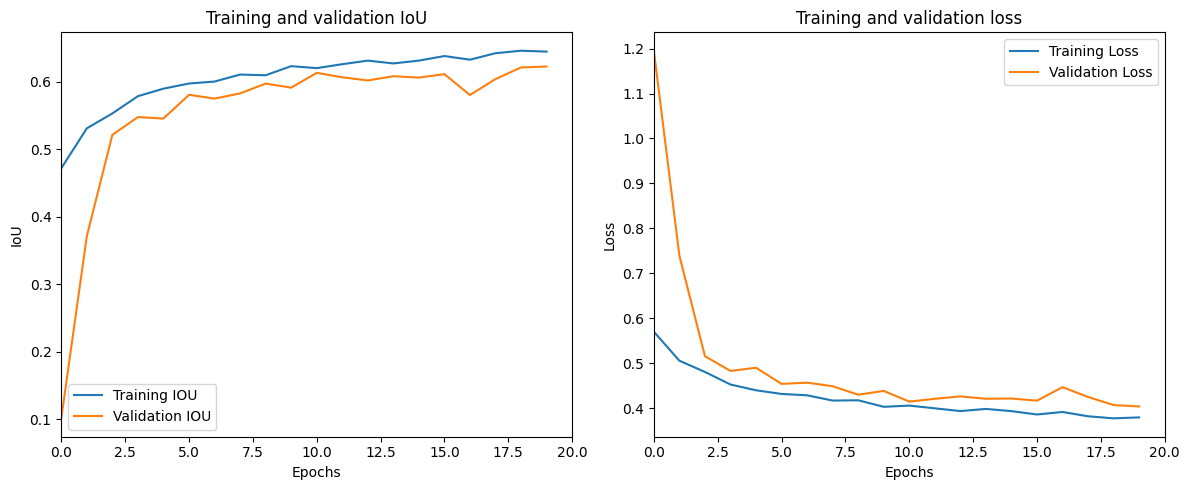

In [16]:
def plot_iou_and_loss(history_file):
    with open(history_file, 'rb') as file:
        history = pickle.load(file)

    # Extract IOU and loss from the history dictionary
    iou = history['iou_score']
    loss = history['loss']
    val_iou = history['val_iou_score']
    val_loss = history['val_loss']

    # Plot IOU
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(iou, label='Training IOU')
    plt.plot(val_iou, label='Validation IOU')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.xlim(0, 20)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim(0, 20)
    
    plt.tight_layout()
    plt.show()

# Usage
history_file = 'landcover/trained_models/history_resnet18_epoch20_FPN.pkl'  # Replace with the path to your history file
plot_iou_and_loss(history_file)

# Model Evaluation

In [57]:
class ImageSegmentationTester:
    """
    The class is designed in a modular and organized way to facilitate the testing and evaluation of image segmentation models.
    It allows for easy comparison of predicted masks with ground truth masks and provides detailed performance metrics for each class.
    It also supports easy visualization of the results, making it valuable for assessing model performance in image segmentation tasks.
    """
    
    def __init__(self, model_path,test_img_path,test_mask_path,num_classes,backbone):
        
        """
        __init__: Initializes the tester with necessary parameters such as the path to the pre-trained model, 
        paths to test images and masks, the number of classes, and the backbone architecture used in the model.
        """
        self.model_path = model_path
        self.model = load_model(self.model_path,compile=False)
        self.num_classes = num_classes
        self.backbone = backbone
        self.test_img_path = test_img_path
        self.test_mask_path = test_mask_path
        self.preprocess_input = sm.get_preprocessing(self.backbone)

    def preprocess_data(self, img, ground_truth):
        
        """
        preprocess_data: Preprocesses input images and ground truth masks by applying Min-Max scaling and model-specific preprocessing. 
        It also one-hot encodes the ground truth masks.
        """
        scaler = MinMaxScaler()
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img = self.preprocess_input(img)
        ground_truth = to_categorical(ground_truth,self.num_classes)
        return img,ground_truth

    def predict(self, test_img,mask_img):
        
        """
        predict: Takes the path to a test image and its corresponding mask, 
        preprocesses the data, and makes predictions using the pre-trained model.
        """
        img = cv2.imread(test_img, 1)  # Read the test image in BGR format
        gt = cv2.imread(mask_img, 0)
        img, ground_truth = self.preprocess_data(img, gt)
        img = np.expand_dims(img, axis=0)  # Add batch dimension for prediction
        prediction = self.model.predict(img)
        return prediction, ground_truth
    
    def evaluate_test_data(self):
        
        """
        evaluate_test_data: Evaluates the model's performance on a set of test images and masks. 
        It computes various metrics such as accuracy, precision, recall, F1-score, and Jaccard score 
        for each class and generates a classification report.
        """
        img_data_gen_args = dict()

        image_datagen = ImageDataGenerator(**img_data_gen_args)
        mask_datagen = ImageDataGenerator(**img_data_gen_args)

        image_generator = image_datagen.flow_from_directory(
            self.test_img_path,
            class_mode=None,
            batch_size=16,
            seed=24)

        mask_generator = mask_datagen.flow_from_directory(
            self.test_mask_path,
            class_mode=None,
            color_mode='grayscale',
            batch_size=16,
            seed=24)

        test_generator = zip(image_generator, mask_generator)

        IOU = MeanIoU(num_classes=self.num_classes)

        total_batches = len(image_generator)

        class_names = ['background', 'building', 'woodland', 'water', 'road'] 

        y_true = []
        y_pred = []

        model_test = load_model(self.model_path, compile=False)

        for _ in range(total_batches):
            (img, mask) = next(test_generator)
            img, mask = self.preprocess_data(img, mask)

            pred = model_test.predict(img)  # Replace 'your_model' with your trained model
            pred_argmax = np.argmax(pred, axis=3)
            mask_batch_argmax = np.argmax(mask, axis=3)

            y_true.extend(mask_batch_argmax.ravel())
            y_pred.extend(pred_argmax.ravel())

        # Generate the classification report
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()

        return report_df
    
#     def get_random_image_names(self, folder_path, num_images_to_pick):
#         image_names = os.listdir(folder_path)
#         random.shuffle(image_names)
#         return image_names[:num_images_to_pick]
    
    def visualize_predictions(self, image_names):
        
        """
        visualize_predictions: Visualizes the original test image, ground truth mask, and predicted mask for a list of image names. 
        It plots these three images side by side for each image in the list.
        """
        #folder_path = self.test_img_path + '/images'
        #image_names = self.get_random_image_names(folder_path, num_images_to_pick)
        num_images = len(image_names)
        
        plt.figure(figsize=(10, 4 * num_images))

        for i in range(num_images):
            image_name = image_names[i]
            test_img_path = os.path.join(self.test_img_path, "images", image_name)
            test_mask_path = os.path.join(self.test_mask_path, "masks", image_name)
            print(test_mask_path)

            prediction, gt = self.predict(test_img_path, test_mask_path)

            pred_mask = np.argmax(prediction[0], axis=2)

            plt.subplot(num_images, 3, i * 3 + 1)
            plt.imshow(cv2.imread(test_img_path, 1))
            plt.title("Original Image")
            
            plt.subplot(num_images, 3, i * 3 + 2)
            plt.imshow(cv2.imread(test_mask_path, 0), cmap='gray')
            plt.title("Ground Truth Mask")

            plt.subplot(num_images, 3, i * 3 + 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")

        plt.show()


landcover/test_masks/masks/M-34-6-A-d-2-2.tifpatch_72.tif
1/1 [==============================] - 1s 770ms/step
landcover/test_masks/masks/N-33-130-A-d-3-3.tifpatch_3433.tif
1/1 [==============================] - 0s 38ms/step
landcover/test_masks/masks/M-34-51-C-d-4-1.tifpatch_2221.tif
1/1 [==============================] - 0s 50ms/step


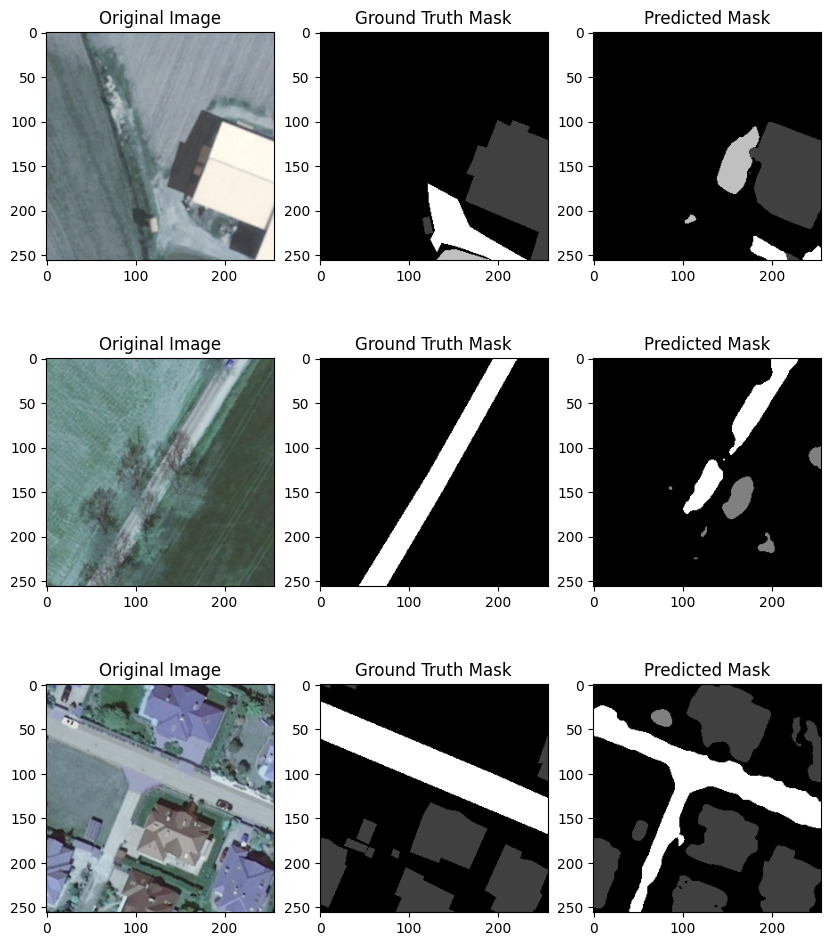

In [51]:
model_path = 'landcover/trained_models/landcover_20_epochs_RESNET18_backbone_batch16.hdf5'
test_img_path = "landcover/test_images/"
test_mask_path = "landcover/test_masks/"

tester = ImageSegmentationTester(model_path, test_img_path,test_mask_path,num_classes=5,backbone='resnet18')
# num_images_to_pick = 3
image_names = [ 'M-34-6-A-d-2-2.tifpatch_72.tif',
               'N-33-130-A-d-3-3.tifpatch_3433.tif',
             'M-34-51-C-d-4-1.tifpatch_2221.tif'
]
tester.visualize_predictions(image_names)
#df_resnet18_Unet = tester.evaluate_test_data()

In [24]:
df_resnet18_Unet

,precision,recall,f1-score,support
background,0.852680,0.912047,0.881365,7.263402e+07
building,0.856163,0.778179,0.815311,2.479341e+06
woodland,0.897686,0.843182,0.869581,5.438494e+07
water,0.886793,0.826483,0.855577,9.828362e+06
road,0.815694,0.658240,0.728557,4.459318e+06
accuracy,0.869972,0.869972,0.869972,8.699715e-01
macro avg,0.861803,0.803626,0.830078,1.437860e+08
weighted avg,0.870948,0.869972,0.869267,1.437860e+08


In [56]:
df_resnet18_Unet.to_csv("Report_Unet_resnet18.csv")

landcover/test_masks/masks/M-34-6-A-d-2-2.tifpatch_72.tif
1/1 [==============================] - 1s 1s/step
landcover/test_masks/masks/N-33-130-A-d-3-3.tifpatch_3433.tif
1/1 [==============================] - 0s 44ms/step
landcover/test_masks/masks/M-34-51-C-d-4-1.tifpatch_2221.tif
1/1 [==============================] - 0s 41ms/step


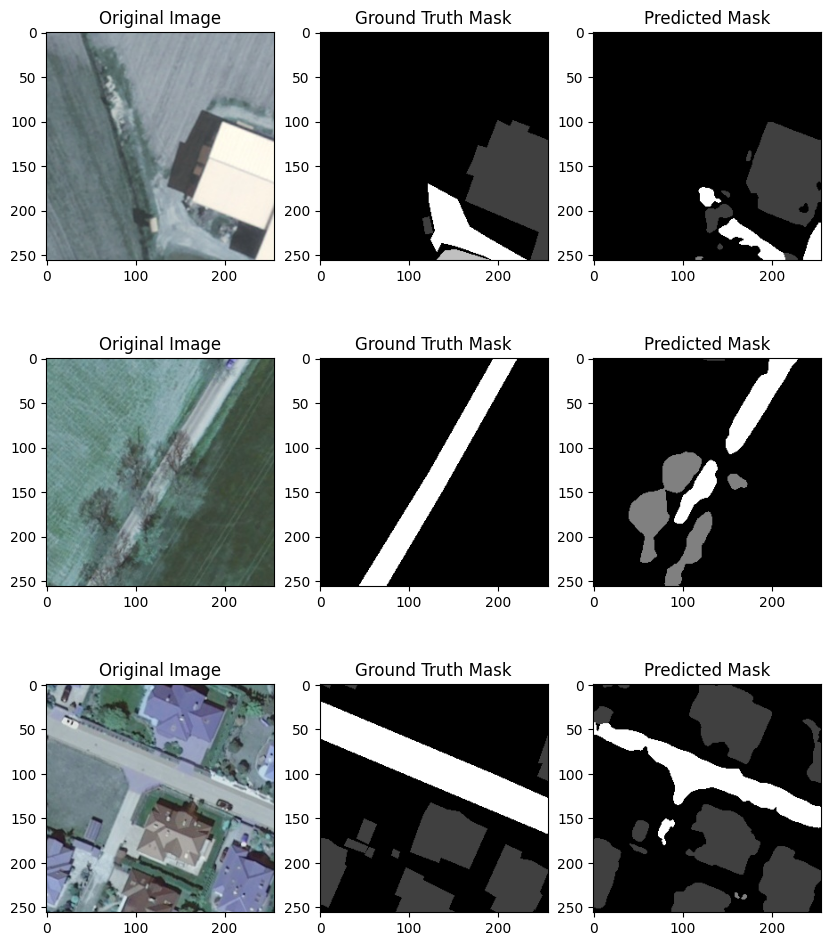

In [50]:
model_path = 'landcover/trained_models/landcover_20_epochs_RESNET50_backbone_batch16.hdf5'
test_img_path = "landcover/test_images/"
test_mask_path = "landcover/test_masks/"

tester = ImageSegmentationTester(model_path, test_img_path,test_mask_path,num_classes=5,backbone='resnet50')
# num_images_to_pick = 3
image_names = [ 'M-34-6-A-d-2-2.tifpatch_72.tif',
               'N-33-130-A-d-3-3.tifpatch_3433.tif',
             'M-34-51-C-d-4-1.tifpatch_2221.tif'
]
tester.visualize_predictions(image_names)
df_resnet50_Unet = tester.evaluate_test_data()

In [29]:
df_resnet50_Unet

,precision,recall,f1-score,support
background,0.833696,0.926363,0.877590,7.263402e+07
building,0.830781,0.815968,0.823308,2.479341e+06
woodland,0.911426,0.813239,0.859538,5.438494e+07
water,0.913065,0.813273,0.860285,9.828362e+06
road,0.813333,0.613406,0.699362,4.459318e+06
accuracy,0.864236,0.864236,0.864236,8.642359e-01
macro avg,0.860460,0.796450,0.824017,1.437860e+08
weighted avg,0.867840,0.864236,0.863116,1.437860e+08


In [55]:
df_resnet50_Unet.to_csv("Report_Unet_resnet50.csv")

landcover/test_masks/masks/M-34-6-A-d-2-2.tifpatch_72.tif
1/1 [==============================] - 1s 779ms/step
landcover/test_masks/masks/N-33-130-A-d-3-3.tifpatch_3433.tif
1/1 [==============================] - 0s 38ms/step
landcover/test_masks/masks/M-34-51-C-d-4-1.tifpatch_2221.tif
1/1 [==============================] - 0s 36ms/step


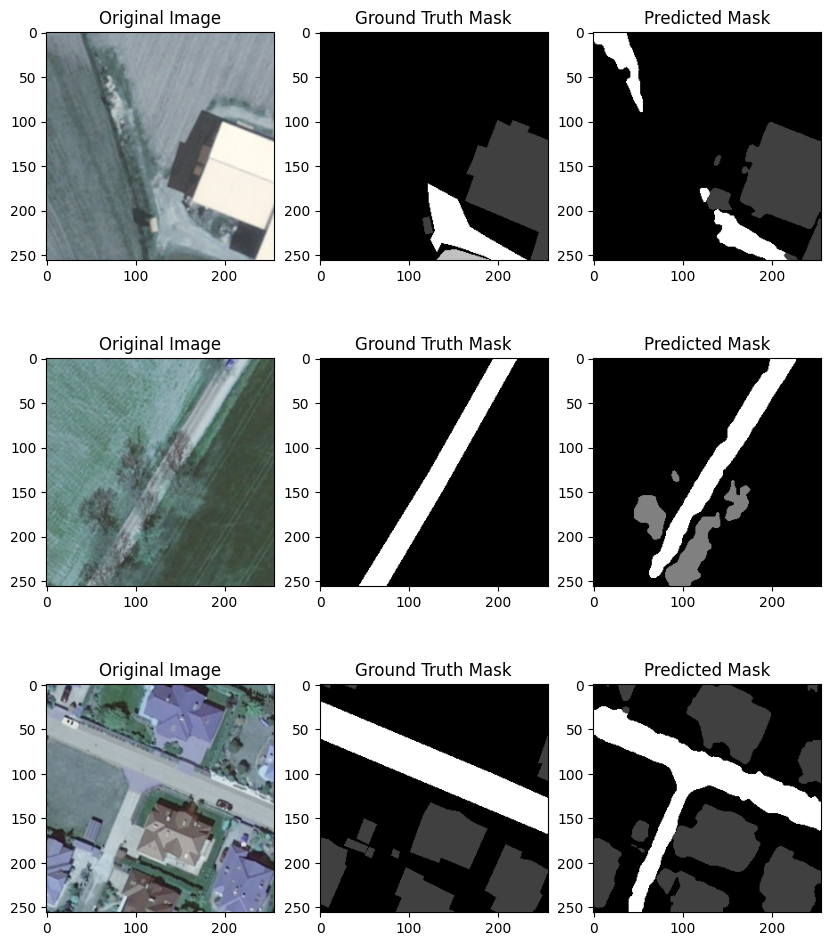

In [49]:
model_path = 'landcover/trained_models/landcover_20_epochs_RESNET18_backbone_batch16_FPN.hdf5'
test_img_path = "landcover/test_images/"
test_mask_path = "landcover/test_masks/"

tester = ImageSegmentationTester(model_path, test_img_path,test_mask_path,num_classes=5,backbone='resnet18')
image_names = [ 'M-34-6-A-d-2-2.tifpatch_72.tif',
               'N-33-130-A-d-3-3.tifpatch_3433.tif',
             'M-34-51-C-d-4-1.tifpatch_2221.tif'
]
tester.visualize_predictions(image_names)
df_resnet18_FPN = tester.evaluate_test_data()

In [54]:
df_resnet18_FPN

,precision,recall,f1-score,support
background,0.880004,0.900593,0.890180,7.263402e+07
building,0.743994,0.885760,0.808712,2.479341e+06
woodland,0.892211,0.873974,0.882998,5.438494e+07
water,0.864126,0.848055,0.856015,9.828362e+06
road,0.799648,0.642312,0.712397,4.459318e+06
accuracy,0.878668,0.878668,0.878668,8.786675e-01
macro avg,0.835997,0.830139,0.830060,1.437860e+08
weighted avg,0.878698,0.878668,0.878209,1.437860e+08


In [53]:
df_resnet18_FPN.to_csv("Report_FPN_resnet18.csv")